# IBM Data Science Professional Specialization - Coursera

This notebook is for the capstone project, fulfilling the requirement for the __[IBM Data Science Professional Specialization](https://www.coursera.org/specializations/ibm-data-science-professional-certificate)__. 


In this analysis, the following content will be listed 
- Web scraping: obtain apartment rental price by neighbourhood
- Data wrangling: clean up the data using python pandas 
- Data analyze:
  - obtain more neighbourhood venue data using Four Square data base, 
  - explore the data set in pandas, matplotlib, etc 
  - perform rental price prediction using machine learning skills  
  
  
  
### Author: Estella Yu ###
email: estellayyu@gmail.com || 
LinkedIn: __[Yingxian Estella Yu](https://www.linkedin.com/in/estella-yingxian-y-65b3b883/)__



keyword:  *`web scraping`*, *`data wrangling`*, *`python`*, *`pandas`*, *`folium`*, *`Four Square`*


# I. Introduction 

### 1. Background

New York is such a unique place full of attractions from the financial capital, fashion trends, artistic and historic atmosphere, that words just simply can't describe enough. The only way to know the life in New York is simply to experience it. Yet, city life comes with a lot of dollar signs _--$$--_  especially in Manhattan. According to the recent National Rent Report (__[Feb 2019](https://www.zumper.com/blog/2019/01/zumper-national-rent-report-february-2019/)__), the rental price in New York for a 1 Bedroom apartment ( **$2,780** ) is ranking 2nd across the nation, right behind the crazy San Fransisco. What's more, based on the data shown in  __[businessinsider](https://www.businessinsider.com/manhattan-rent-by-neighborhood-ranked-from-lowest-to-highest-2018-5)__, the asking rent has drastically increased by **33%** in the window from Dec 2009 to July 2017 (in less than 9 years)!

Therefore, it's of special significance to analyze and understand the housing trend in New York. With some simple search, one can easily spot that the housing price in New York is highly correlated with its location. For example, the rent near Soho (average `$5,000 - $6,000+`) is higher than the Manhattan average by 52%, and is certainly more pricy than the rent near East Harlem (average `$2,000 - $3,000+`). 

So to what extend can we predict the rent in Manhattan based on the neighboring venue, an important component that contributes to the vibes in the neighborhood? Is it easier to spot an Italian restaurant than a pizza store at the pricy neighborhood? How much does a school, a mall, a supermarket potentially contribute to the housing price? We are going to figure it out in this report!

### 2. Project Description

Using data to analyze the following questions: 
 - *`Why`* do we want to analyze the housing price in __New York__?
 - *`How`* is the apartment rental price vary by __neighborhood__?
 - If you are planning to move to a new neighborhood, *`what`* typical __venues__ will you be looking for? 
 - Do the popular venue & higher end apartment price align?

### 3. potential terget reader
The results and analysis enclosed in this project can be closely relevant to: 
 - People related to rental activities in New York (landloard, tenant, real estate agent, ect)
 - Bussiness personal: if one plans to open a new bussiness in a certain neighborhood, which neighborhoods are more appropriate, and do the target neighborhoods have relevant venue already? 
 - or Anyone who's courious about data (like us! :))

# II. Data Description 
### 1. Data Source:
- __[Zumper](https://www.zumper.com/blog/2019/01/zumper-national-rent-report-february-2019/)__: National Rent Report: February 2019
- __[Rentcafe](https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/)__: Manhattan, NY Rental Market Trends
- __[School locations in Manhattan](http://www.lat-long.com/Search.cfm?q=+school&State=NY&County=New+York&FeatureType=school)__
- __[Four Square API](https://developer.foursquare.com/)__: venue data around each neighbourhood

### 2. Data Collection:
 1. Data from National Rent Report and Manhattan rent market trend will be scraped fromthe web
 2. For each neighborhood, it's lattitude and longitude information will be collected using Geocoder
 3. For each neighborhood, call Four Square API to obtain sourounding detailed venue data
 
### 3. Use data to solve the problem:
1. Visualize the national rent price across nation (folium, heat map)
2. Cluster the neighborhood based on rental price, closeby venues, etc.
3. Plot rental price v.s. popular venue across all neighborhood, and explore correlations
4. Analyze a special venue


# III. Import Data

In [1]:
from bs4 import BeautifulSoup # for obtaining clean html content

import numpy as np
import pandas as pd

import requests # for getting html content
import folium
from folium import plugins
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim # convert an address intolatitude and longitude values

import datetime
now = datetime.datetime.now()
date = "%4d%02d%02d" % (now.year, now.month, now.day)

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print("Libraries Imported!")

Libraries Imported!


### 1. extract & plot rental price based on disctrict in Manhattan

    1) use beautiful soup to extract website content

In [2]:
############1. obtain data from website (using BeautyfulSoup)####################
web_link = 'https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/'
web_neighborhood = requests.get(web_link)

soup = BeautifulSoup(web_neighborhood.content, 'html.parser')

    2) clean up the text & extract content in the table

In [3]:
geolocator = Nominatim(user_agent="loc_locator")
priceTable = soup.find("table", id = "MarketTrendsAverageRentTable")
content = priceTable.find_all('tr')
a = []
for con in content:
    pricepair = con.text.lstrip().rstrip()
    pricepair = pricepair.split("\n")

    # there are some exceptions in naming the region (e.g. Theatre District - Times Square)
    # here we only choose the first half (before the "-")
    if ("-" in pricepair[0]):
        pricepair[0] = pricepair[0].split(' - ')[0]
        
    a.append(pricepair[0])
    if 1 < len(a) < 3: a.append(pricepair[1])
    if len(a) > 3:
        a.append(float(pricepair[1].lstrip('$').replace(",","")))
        location = geolocator.geocode("{0}, Manhattan, NY".format(pricepair[0]))
        a.append(float(location.latitude))
        a.append(float(location.longitude))
        

dfTitle = a[1:3]
dfTitle.append('loc_lat')
dfTitle.append('loc_lon')
dfValue = a[3::]
df_manhattan_neighborhood_rent = pd.DataFrame(np.array(dfValue).reshape(len(dfValue)// 4, 4), columns = dfTitle)
df_manhattan_neighborhood_rent.head()

,Neighborhood,Average Rent,loc_lat,loc_lon
0,Marble Hill,1694.0,40.8762983,-73.9104292
1,Inwood,2225.0,40.8692579,-73.9204949
2,Washington Heights,2243.0,40.8401984,-73.9402214
3,Randalls and Wards Islands,2336.0,40.79144785,-73.921023713881
4,East Harlem,3334.0,40.7947222,-73.9425


In [4]:
df_manhattan_neighborhood_rent.shape

(51, 4)

    3) folium visualization 

In [5]:
ny_location = geolocator.geocode("Manhattan, NY")
ny_lat = ny_location.latitude
ny_lon = ny_location.longitude
print('The coordinates of Manhattan, NY are ({}, {})'.format(ny_lat, ny_lon))

The coordinates of Manhattan, NY are (40.7900869, -73.9598295)


In [6]:
# create folium map
manhattan_map = folium.Map(location = [ny_lat, ny_lon], zoom_start = 11.48)

# plot average rental price at each district
for lat, lon, neighborhood, price in zip(df_manhattan_neighborhood_rent['loc_lat'], 
                                         df_manhattan_neighborhood_rent['loc_lon'], 
                                         df_manhattan_neighborhood_rent['Neighborhood'], 
                                         df_manhattan_neighborhood_rent['Average Rent']):
    label = '{}, ${}0'.format(neighborhood, price)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([float(lat), float(lon)],
                        radius = 1, 
                        popup = label, 
                        color = 'red', 
                        opacity = 1,
                        parse_html = False).add_to(manhattan_map)
 
# add heat map 
df_float = df_manhattan_neighborhood_rent.iloc[:, 0:2].copy() # copy the "Neiborhood" and "Average Rent" columns only
df_float['double_lat'] = df_manhattan_neighborhood_rent['loc_lat'].astype(float)
df_float['double_lon'] = df_manhattan_neighborhood_rent['loc_lon'].astype(float)
df_float['heat_map_weights_col'] = ((df_manhattan_neighborhood_rent['Average Rent'].astype(float) - 
                                         df_manhattan_neighborhood_rent['Average Rent'].astype(float).min()) / 
                                    (df_manhattan_neighborhood_rent['Average Rent'].astype(float).max() - 
                                         df_manhattan_neighborhood_rent['Average Rent'].astype(float).min()))
cols_to_pull = ['double_lat', 'double_lon', 'heat_map_weights_col']

PriceList = df_float[cols_to_pull].values.tolist()

manhattan_map.add_child(plugins.HeatMap(PriceList, radius = 15))
manhattan_map

### 2. find neighborhood venues on each district

In [7]:
CLIENT_ID = "RITE5DZBWPGXJKX5S5A2L03WXIAXZOIDDAACBCWIGXO4XAEQ"
CLIENT_SECRET = "HGGFICSXSLIIPMB0QTLVGXVBO3NFMIRKCQFT4PSJDNEJWGOF"
VERSION = date # today's date
limit = 30

In [8]:
# a funtion for generating url when search venues

def url_generator(CLIENT_ID, CLIENT_SECRET, VERSION, LAT, LON, radius, limit):
    url = ("""https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}""" 
              .format(CLIENT_ID, CLIENT_SECRET, VERSION, 
               LAT, LON,
               radius, limit))
        
    return url  

In [9]:
# a function to get the list of venues & organize to a clean list form 

def get_venues(i, CLIENT_ID, CLIENT_SECRET, VERSION, radius, limit):
    # get (lat, lon) from dfa, and generate url for FourSquare request API
    neighborhood = df_float.iloc[i, 0]
    average_price = df_float.iloc[i, 1]
    coord = df_float.iloc[i, 2:4].tolist()
    url = url_generator(CLIENT_ID, CLIENT_SECRET, VERSION, coord[0], coord[1], radius, limit)

    result = requests.get(url).json()

    # get the venues result, and transform to pd.dataframe
    # venues = result['response']['venues']
    
    list_venue = []
    
    for venue in result['response']['venues']:
        if len(venue['categories']) == 0: 
            category = None
        else: 
            category = venue['categories'][0]['name']
            
        list_venue.append((neighborhood, 
                           average_price,
                           venue['name'], 
                           venue['location']['lat'],
                           venue['location']['lng'],
                           category))
    
    return list_venue

In [10]:
# a function to add certain venues to the folium map

def add_venues_to_map(neighborhood,dfName, mapName):
    for lat, lon, venue, category in zip(dfName['lat'], dfName['lon'], dfName['Venue'], dfName['Category']):
        label = 'Neighborhood: {}, Venue: {} ({})'.format(neighborhood, venue, category)
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker([float(lat), float(lon)],
                            radius = 0.5, 
                            popup = label, 
                            color = 'blue', 
                            fill_opacity = 0.2, 
                            parse_html = False).add_to(mapName)

In [11]:
# initiate the list, this will later contain venues from ALL neighborhoods
list_all_venues = []

# loop through each neighborhood, obtain the list of venues at each neighborhood
radius = 1000   # search 1000m from the center of each neighborhood
limit = 100     # get the first 100 venues 

for i in range(df_manhattan_neighborhood_rent.shape[0]):
    # print current progress
    neighborhood = df_manhattan_neighborhood_rent.iloc[i,0];
    print("{}/{}: {}                          ".format(i, 
                                                       df_manhattan_neighborhood_rent.shape[0], 
                                                       neighborhood), end='\r')
    
    current_list_venue = get_venues(i, CLIENT_ID, CLIENT_SECRET, VERSION, radius, limit)
    list_all_venues = list_all_venues + current_list_venue
    
    # create a data frame from current list (optional)
    # To avoid crowdiness, only add the first 10 venues to the map for each neighborhood (optional)
    df_current_venue = pd.DataFrame(current_list_venue) 
    df_current_venue.columns = ['Neighborhood', 'Average_Rent', 'Venue', 'lat' , 'lon', 'Category']
    df_current_venues_top10 = df_current_venue.iloc[0:10,:]
    add_venues_to_map(neighborhood, df_current_venues_top10, manhattan_map)
    
# convert ALL venues to a data frame
df_manhattan_venues = pd.DataFrame(list_all_venues) 
df_manhattan_venues.columns = ['Neighborhood', 'Average_Rent', 'Venue', 'lat' , 'lon', 'Category']
print("All venues found!                     \n")

All venues found!                                         



In [12]:
print('\nThere are {} neighborhoods in NYC'.format(df_manhattan_neighborhood_rent.shape[0]))
print('In total, {} venues are found, and {} of them are unique'.format(df_manhattan_venues.shape[0], 
                                                                   len(df_manhattan_venues['Category'].unique())))

df_manhattan_venues.head()


There are 51 neighborhoods in NYC
In total, 4696 venues are found, and 416 of them are unique


,Neighborhood,Average_Rent,Venue,lat,lon,Category
0,Marble Hill,1694.0,108 Marblehill,40.876605,-73.909430,Housing Development
1,Marble Hill,1694.0,Marble Hill,40.876111,-73.911111,Neighborhood
2,Marble Hill,1694.0,St. Johns Roman Catholic Church,40.876174,-73.909795,Church
3,Marble Hill,1694.0,CTown Supermarkets,40.876218,-73.908541,Supermarket
4,Marble Hill,1694.0,Wine & Liquors,40.874535,-73.909832,Wine Shop


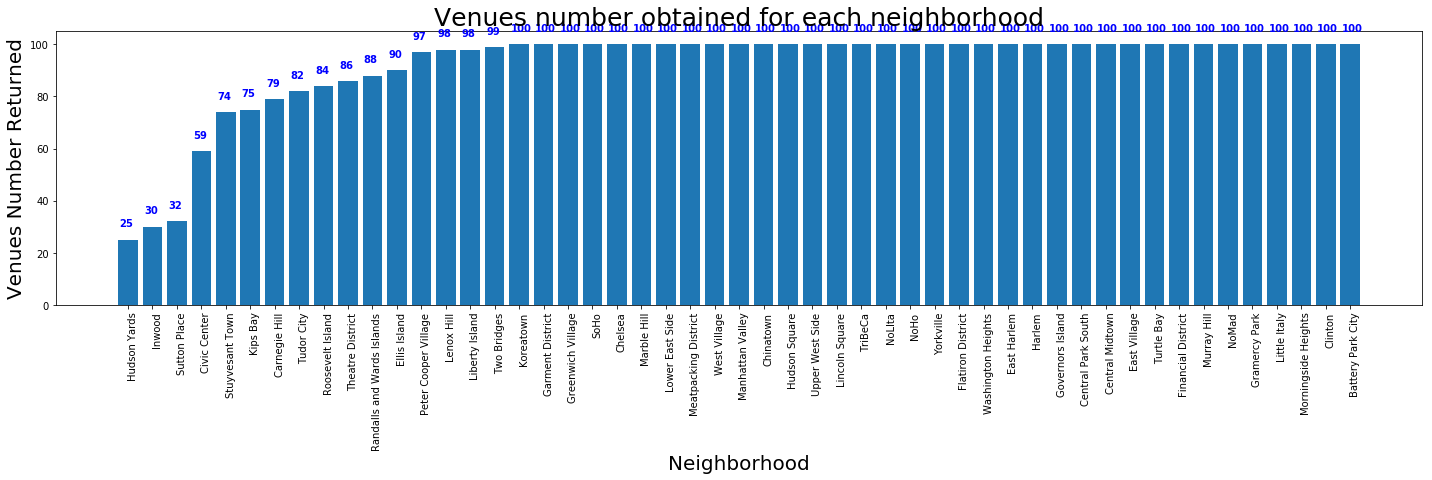

In [13]:
manhattan_neightborhood = list(df_manhattan_venues['Neighborhood'].unique())
venue_num = []
for i in range(len(manhattan_neightborhood)):
    df_1 = df_manhattan_venues[df_manhattan_venues['Neighborhood'] == manhattan_neightborhood[i]]
    venue_num.append(len(df_1))
    
df_venue_num = pd.DataFrame({'Neighborhood': manhattan_neightborhood,'Venue Cound': venue_num})
df_venue_num.columns = ['Neighborhood','Venue Count']
df_venue_num.reset_index(drop = True)
df_venue_num.sort_values(['Venue Count'], inplace = True)

# plot the venues return for each neighborhood
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(df_venue_num['Neighborhood'],df_venue_num['Venue Count'])

plt.xlabel('Neighborhood', fontsize = 20)
plt.ylabel('Venues Number Returned', fontsize = 20)
plt.title('Venues number obtained for each neighborhood', fontsize = 25)
fig.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i, v in enumerate(df_venue_num['Venue Count']):
    ax.text( i - 0.35, v + 5, str(v), color='blue', fontweight='bold')
plt.show()


In [14]:
manhattan_map

# III. Data Analysis

## 1. Data Exploration
*Let's try to see some of the stats of the venues in all the neighborhoods*

*Here's what we have now* --  all the venues and the neighborhood they belong to 

In [15]:
print('\nThere are {} neighborhoods in NYC'.format(df_manhattan_neighborhood_rent.shape[0]))
print('In total, {} venues are found, and {} of them are unique'.format(df_manhattan_venues.shape[0], 
                                                                   len(df_manhattan_venues['Category'].unique())))

df_manhattan_venues.head()


There are 51 neighborhoods in NYC
In total, 4696 venues are found, and 416 of them are unique


,Neighborhood,Average_Rent,Venue,lat,lon,Category
0,Marble Hill,1694.0,108 Marblehill,40.876605,-73.909430,Housing Development
1,Marble Hill,1694.0,Marble Hill,40.876111,-73.911111,Neighborhood
2,Marble Hill,1694.0,St. Johns Roman Catholic Church,40.876174,-73.909795,Church
3,Marble Hill,1694.0,CTown Supermarkets,40.876218,-73.908541,Supermarket
4,Marble Hill,1694.0,Wine & Liquors,40.874535,-73.909832,Wine Shop


### 1.1. One-hot coding --  to get the venue count for each neighborhood

In [16]:
# one-hot coding
df_venues_onehot = pd.get_dummies(df_manhattan_venues[['Category']], prefix = "", prefix_sep = "")

# add neighborhood column & fix the column ordering
df_venues_onehot[['Manhattan_Neighborhood','Average_Rent']] = df_manhattan_venues[['Neighborhood','Average_Rent']]
col = list(df_venues_onehot.columns[-2:]) + list(df_venues_onehot.columns[:-2])
df_venues_onehot = df_venues_onehot[col]

# group by venue categories by neighborhood
df_category_count = df_venues_onehot.groupby(['Manhattan_Neighborhood','Average_Rent']).sum().reset_index()

# add latitute & longitude back
df_getLatLon = df_manhattan_neighborhood_rent.copy().sort_values(by = ['Neighborhood']).reset_index(drop = True)
df_category_count[['lat','lon']] =  df_getLatLon[['loc_lat','loc_lon']]
col = (list(df_category_count.columns[0:2]) +
       list(df_category_count.columns[-2:]) + 
       list(df_category_count.columns[2:-2]))
df_category_count = df_category_count[col]
print(df_category_count.shape)
df_category_count.head()

(51, 419)


,Manhattan_Neighborhood,Average_Rent,lat,lon,ATM,Accessories Store,Acupuncturist,Advertising Agency,African Restaurant,Alternative Healer,...,Warehouse,Watch Shop,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,5603.0,40.7110166,-74.0169369,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Carnegie Hill,4271.0,40.7841972,-73.954339,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,Central Midtown,3913.0,40.7622684,-73.9795443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Central Park South,3786.0,40.7646364,-73.9737661,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,Chelsea,4359.0,40.7464906,-74.0015283,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### 1.2. top 50 venues across all neighborhoods
Across all neighborhoods, there are 419 unique venues -- *but are they all useful in predicting the price trend?*

Let's see what are the top ranking venues in all neighborhoods

__*1) get data frame that counts the appearance of each venue type across all neightborhood*__

In [17]:
df_temp = df_venues_onehot.drop(columns = ['Average_Rent'])
df_venues_grouped = df_temp.groupby(['Manhattan_Neighborhood']).sum()
df_venued_grouped_count = df_venues_grouped.sum().sort_values(ascending = False).reset_index()
df_venued_grouped_count.columns = [['Venues','Count']]
df_venued_grouped_count.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,405,406,407,408,409,410,411,412,413,414
Venues,Residential Building (Apartment / Condo),Office,Building,Doctor's Office,Food Truck,Coffee Shop,Laundry Service,Salon / Barbershop,Art Gallery,Deli / Bodega,...,Music Store,Museum,Motel,Memorial Site,Medical Supply Store,Malay Restaurant,College Basketball Court,Lingerie Store,Law School,IT Services
Count,339,253,193,115,77,63,61,60,54,51,...,1,1,1,1,1,1,1,1,1,1


__*2) Plot the top 50 venues*__

In [18]:
# extract the venue names and their counts into two lists -- for plotting
venues = list(df_venued_grouped_count['Venues'].astype('str').apply(','.join))[0].split(',')
venues_count = list(pd.to_numeric(df_venued_grouped_count.iloc[:,1], errors='coerce'))

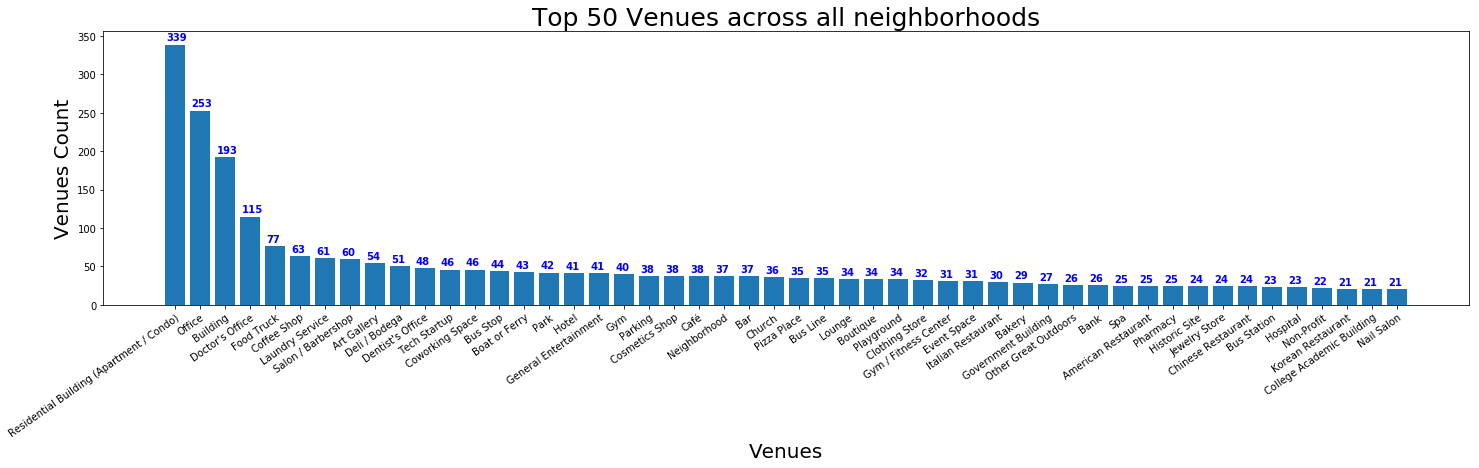

In [19]:
# bar chart showing the top 50 venues
fig, ax = plt.subplots(figsize=(20,5))

num_top = 50
ax.bar(venues[0:num_top], venues_count[0:num_top])
plt.xlabel('Venues', fontsize = 20)
plt.ylabel('Venues Count', fontsize = 20)
plt.title('Top {} Venues across all neighborhoods'.format(num_top), fontsize = 25)
fig.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=35, ha="right",
         rotation_mode="anchor")
for i, v in enumerate(venues_count[0:num_top]):
    ax.text( i - 0.35, v + 5, str(v), color='blue', fontweight='bold')
plt.show()

__*3) Plot the sum number of top 100 venues*__

as we can see from the previous part, the populairy of venues decay quickly

- we might not need all of the venues for our analysis
- the non-popular ones are not covering many neighborhoods, and might not be that helpful anyway

In [20]:
sum_list = [0, 10, 20, 50, 100, 150, 200, 300]
count_sum_list = np.array([])
count_percent_list = np.array([])
for ind in sum_list:
    cnt_sum = df_venued_grouped_count['Count'][:ind].sum()
    cnt_percent = cnt_sum/df_manhattan_venues.shape[0]
    count_sum_list = np.append(count_sum_list, cnt_sum)
    count_percent_list = np.append(count_percent_list,cnt_percent)

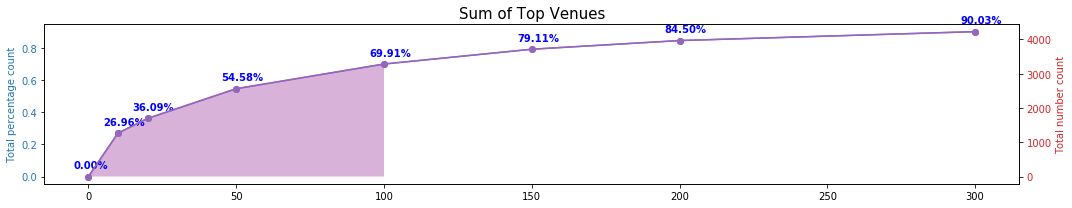

In [21]:
fig, ax1 = plt.subplots(figsize=(15,3))

color = 'tab:blue'
ax1.set_ylabel('Total percentage count', color=color)  # we already handled the x-label with ax1

ax1.plot(sum_list, count_percent_list,'r-o', color = 'tab:purple')
ax1.fill_between(sum_list[:5], 0, count_percent_list[:5],
                facecolor = 'purple',
                alpha = 0.3)
for i, v in enumerate(count_percent_list):
    ax1.text( sum_list[i]-5 , v+0.05 , '%.2f%%'% (v*100), color='blue', fontweight='bold')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Total number count', color=color)
ax2.plot(sum_list, count_sum_list,'r-o', color = 'tab:purple')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sum of Top Venues', fontsize = 15)
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

__In fact, if we only use the top 100 most popular venues, we can cover 70+% of the total number venues__

So in the remainer of the analysis, let's only use the top 100 venues

In [22]:
top_num_venues = 100
top_venues = venues[0:top_num_venues]

In [23]:
# this will generate a data frame that only contains the top 100 venues
rowind = []
for ind in range(df_manhattan_venues.shape[0]):
    if df_manhattan_venues.iloc[ind, -1] in top_venues:
        rowind.append(ind)
        
df_manhattan_top_venues = df_manhattan_venues.iloc[rowind, :]
df_manhattan_top_venues = df_manhattan_top_venues.reset_index(drop = True)
print(df_manhattan_top_venues.shape)
df_manhattan_top_venues.head()

(3283, 6)


,Neighborhood,Average_Rent,Venue,lat,lon,Category
0,Marble Hill,1694.0,108 Marblehill,40.876605,-73.909430,Housing Development
1,Marble Hill,1694.0,Marble Hill,40.876111,-73.911111,Neighborhood
2,Marble Hill,1694.0,St. Johns Roman Catholic Church,40.876174,-73.909795,Church
3,Marble Hill,1694.0,Wine & Liquors,40.874535,-73.909832,Wine Shop
4,Marble Hill,1694.0,flowers by Zenda,40.874875,-73.909399,Flower Shop


## 2. Simple Linear Regression
*Let's try to blindly linear regress the venues and the housing price, and see what we can get*

In [24]:
df_manhattan_top_venue_onehot = pd.get_dummies(df_manhattan_top_venues[['Category']], prefix = '', prefix_sep = '')
df_manhattan_top_venue_onehot[['Manhattan Neighborhood',
                               'Average_Rent']] = df_manhattan_top_venues[['Neighborhood',
                                                                           'Average_Rent']]
col = (list(df_manhattan_top_venue_onehot.columns[-2:]) + 
       list(df_manhattan_top_venue_onehot.columns[:-2]))
df_manhattan_top_venue_onehot = df_manhattan_top_venue_onehot[col]
df_manhattan_top_venue_onehot_grouped = df_manhattan_top_venue_onehot.groupby(['Manhattan Neighborhood',
                                                                               'Average_Rent']).sum()
df_manhattan_top_venue_onehot_grouped = df_manhattan_top_venue_onehot_grouped.sort_values(['Average_Rent'],
                                                                                 ascending = False).reset_index()
df_manhattan_top_venue_onehot_grouped['Average_Rent'] = pd.to_numeric(
                                                            df_manhattan_top_venue_onehot_grouped.iloc[:,1], 
                                                                      errors='coerce')
print(df_manhattan_top_venue_onehot_grouped.shape)
df_manhattan_top_venue_onehot_grouped.head()

(51, 102)


,Manhattan Neighborhood,Average_Rent,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Baseball Field,Basketball Court,...,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Spa,Sushi Restaurant,Tech Startup,Theater,Wine Shop,Women's Store
0,Battery Park City,5603.0,1,1,0,1,1,2,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Little Italy,4845.0,0,2,0,2,0,1,0,0,...,0,1,1,0,3,0,2,0,0,0
2,TriBeCa,4845.0,2,1,1,2,1,1,0,0,...,0,0,0,0,0,1,0,0,2,0
3,Lincoln Square,4706.0,1,2,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,Upper West Side,4654.0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,3,0,0


In [25]:
lreg = LinearRegression()
y = np.asarray(df_manhattan_top_venue_onehot_grouped.iloc[:,1])
y = np.array((np.max(y) - y) / (np.max(y) - np.min(y)))
r2 = []
slope = []

for i in range(df_manhattan_top_venue_onehot_grouped.shape[1]-2):
    x = np.array(list(df_manhattan_top_venue_onehot_grouped.iloc[:,i+2]))
    x = x.reshape(-1, 1)
    model = lreg.fit(x, y)
    r2.append(lreg.score(x,y))
    slope.append(lreg.coef_)

[Text(0, 0.5, 'Slope'), Text(0.5, 0, 'Venue polularity')]

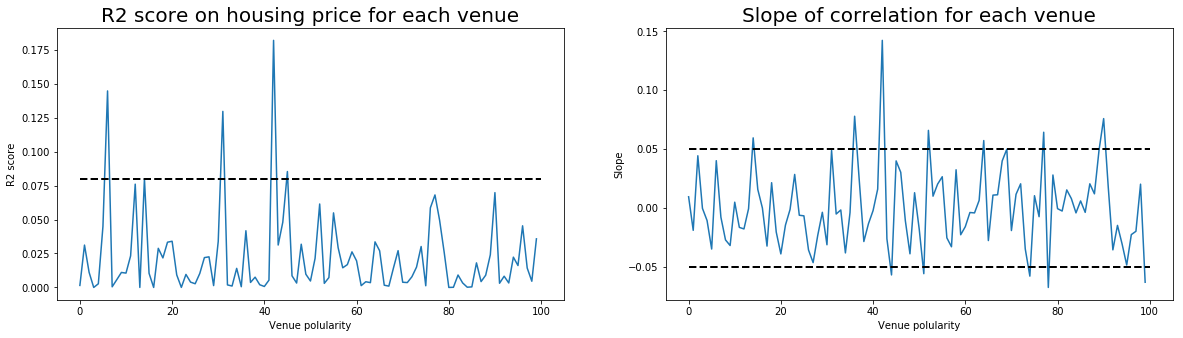

In [26]:
r2_cr = 0.08
slope_cr = 0.05

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (20,5))
ax = axs[0]
ax.plot(range(df_manhattan_top_venue_onehot_grouped.shape[1]-2), r2)
ax.plot([0, top_num_venues], [r2_cr,r2_cr],color='k', linestyle='--', linewidth=2)
ax.set_title('R2 score on housing price for each venue', fontsize = 20)
ax.set(xlabel='Venue polularity', ylabel='R2 score')

ax = axs[1]
ax.plot(range(df_manhattan_top_venue_onehot_grouped.shape[1]-2), slope)
ax.plot([0, top_num_venues], [slope_cr,slope_cr],color='k', linestyle='--', linewidth=2)
ax.plot([0, top_num_venues], [-slope_cr,-slope_cr],color='k', linestyle='--', linewidth=2)
ax.set_title('Slope of correlation for each venue', fontsize = 20)
ax.set(xlabel='Venue polularity', ylabel='Slope')

In [27]:
for i in range(df_manhattan_top_venue_onehot_grouped.shape[1]-2):
    if ((r2[i] > r2_cr) and abs(slope[i]) > slope_cr):
        print('{}: {},   R2 = {}, Coef = {}'.format(i,venues[i], r2[i], slope[i]))

42: Jewelry Store,   R2 = 0.18184969600488632, Coef = [0.14237925]


In [29]:
df_top100_venued_grouped_count.head()

,Venues,Count,r2,correlation,Scaled_r2,Scaled_corr
0,Residential Building (Apartment / Condo),339,0.001493,0.009527,-0.680708,0.273803
1,Office,253,0.031179,-0.018975,0.294020,-0.559502
2,Building,193,0.011109,0.044370,-0.364966,1.292470
3,Doctor's Office,115,0.000002,-0.000299,-0.729652,-0.013497
4,Food Truck,77,0.002692,-0.010631,-0.641318,-0.315543


### 2. obtain top venues in each neighborhood

In [30]:
# a function return the most n top-venues for each neighborhood
def return_most_common_venues(row, num_top_venues, from_col):
    
    row_categories = row.iloc[int(from_col):]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted#.index.values[:num_top_venues]

# a function to return the header for the "Most-Common-Venue" dataframe
def create_most_common_col_name(num_top_venues):
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = []
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    return columns

In [31]:
# create a new dataframe
num_top_venues = 5
neighborhoods_venues_sorted = pd.DataFrame(columns=create_most_common_col_name(num_top_venues))

# append the cols to the beginning of the dataframe
col = ['Manhattan_Neighborhood','Average_Rent','lat','lon']
neighborhoods_venues_sorted[col] = df_category_count[col]
fixed_columns = (list(neighborhoods_venues_sorted.columns[-len(col):]) + 
                                                         list(neighborhoods_venues_sorted.columns[:-len(col)]))
neighborhoods_venues_sorted = neighborhoods_venues_sorted[fixed_columns]

for ind in np.arange(df_category_count.shape[0]):
    df_temp = return_most_common_venues(df_category_count.iloc[ind, :], num_top_venues, 4)
    neighborhoods_venues_sorted.iloc[ind, len(col):] = df_temp.index.values[:num_top_venues]

neighborhoods_venues_sorted.head()

,Manhattan_Neighborhood,Average_Rent,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,5603.0,40.7110166,-74.0169369,Residential Building (Apartment / Condo),Building,Office,Park,Gym
1,Carnegie Hill,4271.0,40.7841972,-73.954339,Doctor's Office,Residential Building (Apartment / Condo),Building,School,Church
2,Central Midtown,3913.0,40.7622684,-73.9795443,Office,Food Truck,Event Space,Building,Convention Center
3,Central Park South,3786.0,40.7646364,-73.9737661,Office,Food Truck,Building,Hotel Bar,Cosmetics Shop
4,Chelsea,4359.0,40.7464906,-74.0015283,Residential Building (Apartment / Condo),Laundry Service,Building,Doctor's Office,Office


### 3. cluster neighborhoods 

In [32]:
# a function to calculate dist between 2 points
def two_pt_distance_sq(p1, p2):
    if len(p1) != len(p2):
        return "Error: dimension not match"
    
    l = len(p1)
    sum_dist = 0
    for i in range(l):
        sum_dist += np.square(p1[i] - p2[i])
    return sum_dist

# a function to calculate distance between cluster center and all pts belong to that cluster
def sum_dist_to_mean(cluster_center, x_in_the_same_cluster):
    n_pts = x.shape[0]
    dist = 0
    for ind in range(n_pts):
        dist += two_pt_distance_sq(cluster_center, x.iloc[ind,:])
    return dist

In [33]:
# append the cols to the beginning of the dataframe
col = ['lat','lon']
df_manhattan_top_venue_onehot_grouped[col] = df_category_count[col]
fixed_columns = (list(df_manhattan_top_venue_onehot_grouped.columns[:2]) + 
                     list(df_manhattan_top_venue_onehot_grouped.columns[-len(col):]) + 
                     list(df_manhattan_top_venue_onehot_grouped.columns[2:-len(col)]))
df_manhattan_top_venue_onehot_grouped = df_manhattan_top_venue_onehot_grouped[fixed_columns]

### 3.1. use elbow method to get the best k

In [34]:
df_manhattan_top_venue_onehot_grouped.head()

,Manhattan Neighborhood,Average_Rent,lat,lon,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,...,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Spa,Sushi Restaurant,Tech Startup,Theater,Wine Shop,Women's Store
0,Battery Park City,5603.0,40.7110166,-74.0169369,1,1,0,1,1,2,...,0,0,0,0,0,0,1,0,0,0
1,Little Italy,4845.0,40.7841972,-73.954339,0,2,0,2,0,1,...,0,1,1,0,3,0,2,0,0,0
2,TriBeCa,4845.0,40.7622684,-73.9795443,2,1,1,2,1,1,...,0,0,0,0,0,1,0,0,2,0
3,Lincoln Square,4706.0,40.7646364,-73.9737661,1,2,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,Upper West Side,4654.0,40.7464906,-74.0015283,0,0,0,0,0,1,...,0,1,1,0,0,1,0,3,0,0


[Text(0, 0.5, 'square error'), Text(0.5, 0, 'k clusters')]

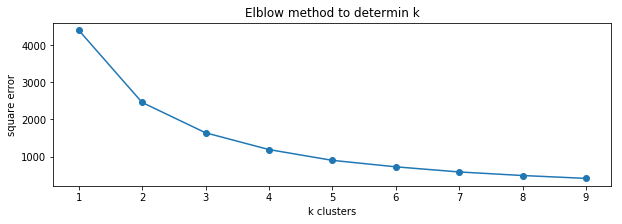

In [35]:
# loop for multiple values of cluster numbers     
    
sum_dist_to_cluster_mean = []
k_max = 10
for i in range(1, k_max):
    # set number of clusters
    kclusters = 1 + i
    manhattan_neighborhood_clustering = df_manhattan_top_venue_onehot_grouped.iloc[:, 4:]
    
    ##print(df_manhattan_top_venue_onehot_grouped.head())
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_neighborhood_clustering)
     
    # add clustering labels
    df_manhattan_clustered_all_venue = df_manhattan_top_venue_onehot_grouped.copy()
    df_manhattan_clustered_all_venue.insert(0, 'Cluster Labels', kmeans.labels_)
    df_manhattan_clustered_all_venue.sort_values('Cluster Labels',
                                                 axis=0, ascending=True,
                                                 inplace=True, na_position='last')
    
    dist = 0
    for j in range(kclusters):
        x = df_manhattan_clustered_all_venue[df_manhattan_clustered_all_venue['Cluster Labels'] == j ].iloc[:,5:]
        cluster_center = kmeans.cluster_centers_[j]
        dist += sum_dist_to_mean(cluster_center,x)
    sum_dist_to_cluster_mean.append(dist/kclusters)
    
fig, axs = plt.subplots(1, 1, figsize = (10,3))
axs.plot(range(1, k_max) ,sum_dist_to_cluster_mean,'-o')
axs.set_title('Elblow method to determin k')
axs.set(xlabel='k clusters', ylabel='square error')

In [36]:
# set number of clusters
kclusters = 4

manhattan_neighborhood_clustering = df_category_count.iloc[:, 2:]
print(manhattan_neighborhood_clustering.shape)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:manhattan_neighborhood_clustering.shape[0]]

(51, 417)


array([1, 2, 3, 3, 2, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 2, 1, 1, 3, 1, 1, 1,
       1, 1, 0, 1, 3, 2, 1, 1, 1, 1, 2, 3, 1, 3, 2, 1, 1, 3, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 2], dtype=int32)

In [37]:
# add clustering labels
df_manhattan_clustered_all_venue = neighborhoods_venues_sorted.copy()
df_manhattan_clustered_all_venue.insert(0, 'Cluster Labels', kmeans.labels_)
df_manhattan_clustered_all_venue.sort_values('Cluster Labels',axis=0,ascending=True,inplace=True,na_position='last')
df_manhattan_clustered_all_venue.head()

,Cluster Labels,Manhattan_Neighborhood,Average_Rent,lat,lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,0,Liberty Island,3718.0,40.6897882,-74.0451182096341,Boat or Ferry,Monument / Landmark,Harbor / Marina,History Museum,Scenic Lookout
10,0,Ellis Island,3718.0,40.6992693,-74.0393071,Boat or Ferry,Harbor / Marina,History Museum,Monument / Landmark,American Restaurant
0,1,Battery Park City,5603.0,40.7110166,-74.0169369,Residential Building (Apartment / Condo),Building,Office,Park,Gym
23,1,Lenox Hill,4332.0,40.7664366,-73.9590168,Residential Building (Apartment / Condo),Laundry Service,Coffee Shop,Doctor's Office,Salon / Barbershop
49,1,West Village,4524.0,40.7352405,-74.0046133971969,Boutique,Residential Building (Apartment / Condo),Clothing Store,Cosmetics Shop,Building


In [38]:
# add clustering labels
df_manhattan_clustered_grouped = df_category_count.iloc[:,4:].copy()
df_manhattan_clustered_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
df_manhattan_clustered_grouped.head()
df_k_types = df_manhattan_clustered_grouped.groupby('Cluster Labels').sum().reset_index()

In [39]:
# create a new dataframe
num_top_venues = 5
neighborhoods_k_clustered = pd.DataFrame(columns=create_most_common_col_name(num_top_venues))
neighborhoods_k_clustered[['Cluster Labels']] = df_k_types[['Cluster Labels']]
col = list(neighborhoods_k_clustered.columns[-1:]) + list(neighborhoods_k_clustered.columns[:-1])
neighborhoods_k_clustered = neighborhoods_k_clustered[col]

bar = pd.DataFrame(columns=create_most_common_col_name(num_top_venues))
bar[['Cluster Labels']] = df_k_types[['Cluster Labels']]
col = list(bar.columns[-1:]) + list(bar.columns[:-1])
bar = bar[col]

for ind in np.arange(df_k_types.shape[0]):
    df_most_commone_venue = return_most_common_venues(df_k_types.iloc[ind, 1:], 
                                                                            num_top_venues, 1)
    list_most_common = df_most_commone_venue.index.values[:num_top_venues]
    neighborhoods_k_clustered.iloc[ind, 1:] = list_most_common
    
    list_most_common_count = df_most_commone_venue[:num_top_venues]/df_most_commone_venue.sum()
    bar.iloc[ind, 1:] = list(list_most_common_count)

neighborhoods_k_clustered

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Boat or Ferry,Harbor / Marina,Monument / Landmark,History Museum,American Restaurant
1,1,Residential Building (Apartment / Condo),Building,Office,Doctor's Office,Deli / Bodega
2,2,Residential Building (Apartment / Condo),Doctor's Office,Office,Building,Dentist's Office
3,3,Office,Building,Food Truck,Tech Startup,Coworking Space


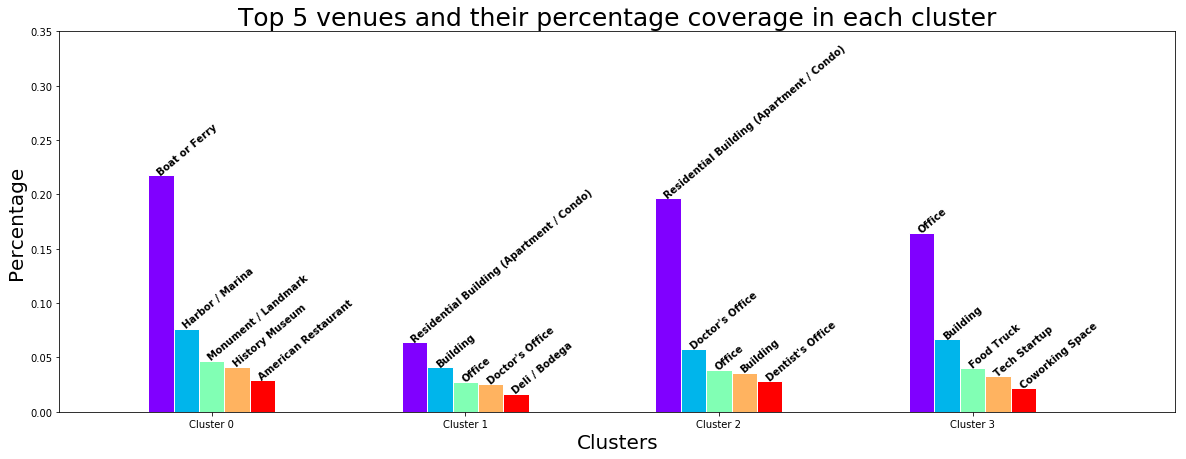

In [96]:
barWidth = 0.25
colors_array = cm.rainbow(np.linspace(0, 1, bar.shape[1]-1))
plt.figure(figsize=(20,7))
plt.xlim((-1, 10))
plt.ylim((0,0.35))
xticks_label = []
for i in range(bar.shape[1]-1):
    if i == 0:
        x = 2.5 * np.arange(bar.shape[0])
    else:
        x = x + barWidth 
    plt.bar(x, bar.iloc[:,i + 1], color=colors_array[i], width=barWidth, edgecolor='white', label='var1')
    for u, v in enumerate(bar.iloc[:,i + 1]):
        plt.text(x[u], v , neighborhoods_k_clustered.iloc[u,i + 1], 
                 color='black', fontweight='bold', rotation=40, ha="left", rotation_mode="anchor")

for j in range(kclusters):
    xticks_label.append('Cluster {}'.format(bar.iloc[j,0]))
    
plt.xlabel('Clusters', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.title('Top {} venues and their percentage coverage in each cluster'.format(kclusters + 1), fontsize = 25)
plt.xticks([x + (num_top_venues // 2)* barWidth for x in 2.5 * np.arange(bar.shape[0])], xticks_label);


As it can be seen from the bar chart above, when comparing the top venues in each cluster, they are very well separated by their functions. We can now provide them with names based on these characteristics:
- Cluster 0: Island/Coastal Region
- Cluster 1: Multifunctional Region
- Cluster 2: Residential Region
- Cluster 3: Bussiness Region


In [75]:
clustered_map = folium.Map(location = [ny_lat, ny_lon], zoom_start= 11.45)
cluster_name = ['Cluster 0 - Island/Coastal Region', 
                'Cluster 1 - Multifunctional Region', 
                'Cluster 2 - Residential Region',
                'Cluster 3 - Bussiness Region']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, rent, cluster in zip(df_manhattan_clustered_all_venue['lat'], 
                                  df_manhattan_clustered_all_venue['lon'], 
                                  df_manhattan_clustered_all_venue['Manhattan_Neighborhood'], 
                                  df_manhattan_clustered_all_venue['Average_Rent'],
                                  df_manhattan_clustered_all_venue['Cluster Labels']):
    
    label = folium.Popup(str(neighborhood) +', $'+ rent + "0 : (" +
                         cluster_name[cluster] + ")",
                         parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clustered_map)
       
clustered_map

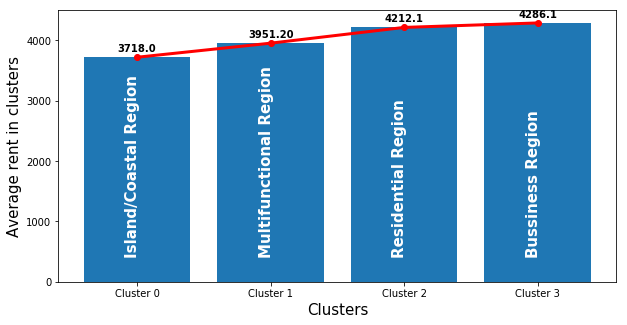

In [95]:
def average(aList):
    return sum(aList)/len(aList)

average_price = []
for i in range(kclusters):
    ave_price = average(list(df_manhattan_clustered_all_venue
                 [df_manhattan_clustered_all_venue
                  ['Cluster Labels'] == i]['Average_Rent'].astype(float)))
    average_price.append(ave_price)
plt.figure(figsize=(10,5))   
plt.bar(range(kclusters),average_price);
plt.plot(range(kclusters),average_price,'r-o',linewidth = 3);
plt.xticks([x for x in np.arange(bar.shape[0])], xticks_label);
plt.xlabel('Clusters', fontsize = 15)
plt.ylabel('Average rent in clusters', fontsize = 15)
for i in range(kclusters):
    plt.text(x[i], average_price[i] + 100, str(average_price[i])[:7], 
                 color='black', fontweight='bold', ha="center", rotation_mode="anchor")
    plt.text(x[i], 400 , cluster_name[i].split('- ')[-1], 
                 color='white', fontweight='bold', rotation=90, ha="left", rotation_mode="anchor", fontsize = 15)

# IV. Discussion 

As mentioned before, __New York__ is a big city with a __high population density in a narrow area__. Different aspects of analysis can be made across these `51 districts`, and can vary drastically in each analysis. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield high quality results for this metropol.

I used the `Kmeans` algorithm as part of this clustering study. Since the venues are very packed and diversed in almost all districts, a sharp elbow transition is not obvious from the plot generated. Based on the figure, though, I set the optimum k value to 4. Surprisingly, the clustered results makes sense, and the 51 districts can be group to __4 distinct regions__ -- __1)__ `Island/Coastal region`, __2)__ `Multifunctional region`, __3)__ `residential region`, and __4)__ `bussiness region`. These regions made sense geographically as well, as shown in the folium map -- with the 2 islands marked as the "Island region", the famous tourist districts (e.g. SoHo, Financial district, etc) marked as "Bussiness Region", etc. 

However, in each of the 51 districts, only 1 geological coordinate was used. For more detailed and accurate guidance, the data set can be expanded and the details of the neighborhood or street can also be drilled.

I also performed a simple `regression analysis` on each unique type of venue in the data set, which though sparse, provided some of the guidelines for predicting the positive/negative effects in rental price. Since the venues covered in each districts vary a lot, the 1D analysis does not provide prediction with high confidence. Yet, it shows, for example, a district with more __jewlery stores__ generally have a __higher rental price__. In future studies, these analysis can be performed in a cluster basis instead, since the districts in the same cluster tend to share more similar venues. Furthermore, one can relate the rental price with time, and plot the price trend throughout different period of time in the year as well. 

I ended the study by visualizing the data and clustering information on the New York map on folium. In future studies, web or app applications can be carried out to direct investors.

# V. Summary

As a result, this study can be useful for a person looking for a new rental place, as not only the rental price and neighborhood venues have certain correlation, but the nearby venues also determine whether a place is ideal to live in. For this reason, people can achieve better outcomes through their access to the platforms where such information is provided.

Furthermore, it can also benefit for bussiness personals who are looking for apartments or strores to invest in. Not to mention this type of analytic methods can also be generalize to analyze data sets in many different cities across the world. 